# Dynamic Mode Decomposition example

[Dynamic Mode Decomposition](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition) (DMD) is a dimensionality reduction algorithm that enables spatio-temporal patterns to be extracted from high-dimensional time-series data without any knowledge about the processes that generated the data. It was developed in 2008 to study fluid mechanics ([original paper](https://doi.org/10.1017/S0022112010001217)) but has since been applied in biology, finance, meteorology, and many other fields.

This notebook contains a summary of the algorithm and a Python implementation of exact DMD.


## Equations

Consider time-series data that contains $n$ measurements over $m$ time points. Data at time point $i$ can be represented as a column vector

$$
\mathbf{x}_i = 
\begin{bmatrix}
x_{i1} \\
\vdots \\
x_{in}
\end{bmatrix}
$$

The following $n \times (m - 1)$ matrices can be formed from the column vectors:

$$
\mathbf{X} = 
\begin{bmatrix}
\mathbf{x}_1 & \dots &  \mathbf{x}_{m-1}
\end{bmatrix}
$$

$$
\mathbf{X'} = 
\begin{bmatrix}
\mathbf{x}_{2} & \dots &  \mathbf{x}_{m}
\end{bmatrix}
$$

The idea in DMD is to find the best linear operator $\mathbf{A}$ that maps $\mathbf{X}$ into $\mathbf{X}'$ (i.e., $\mathbf{X}' \approx \mathbf{A} \mathbf{X}$) by approximating leading eigenvalues and eigenvectors of $\mathbf{A}$ without actually having to compute $\mathbf{A}$. This is because for most systems of interest, $\mathbf{A}$ will be very large!

We can use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to decompose $\mathbf{X}$:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^*
$$

From the equations above we can derive the following expression:

$$
\mathbf{U}^* \mathbf{X}' \mathbf{V} \mathbf{\Sigma}^{-1} = \mathbf{U}^* \mathbf{A} \mathbf{U} = \mathbf{\tilde{A}}
$$

where $\mathbf{\tilde{A}}$ is a reduced linear operator that tells us how the modes evolve over time. $\mathbf{\tilde{A}}$ and $\mathbf{A}$ have the same non-zero eigenvalues $\mathbf{\Lambda}$. Eigenvectors of $\mathbf{A}$ can be calculated as 

$$
\mathbf{\Phi} = \mathbf{X}' \mathbf{V} \mathbf{\Sigma}^{-1} \mathbf{W}
$$

where $\mathbf{W}$ are the eigenvectors of $\mathbf{\tilde{A}}$.

The result of DMD is the eigenvalues $\mathbf{\Lambda}$ that describe the growth/decay and oscillations of the modes $\mathbf{\Phi}$. If the imaginary part of the eigenvalue is non-zero, the corresponding mode oscillates. If the absolute value of the eigenvalue is non-zero, the corresponding mode grows/decays exponentially.

## Code

Let's start by defining a one-dimensional system consists of two separate modes evolving over time (inspiration drawn from [pydmd](https://mathlab.github.io/PyDMD/)'s tutorial).

/home/leevi/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


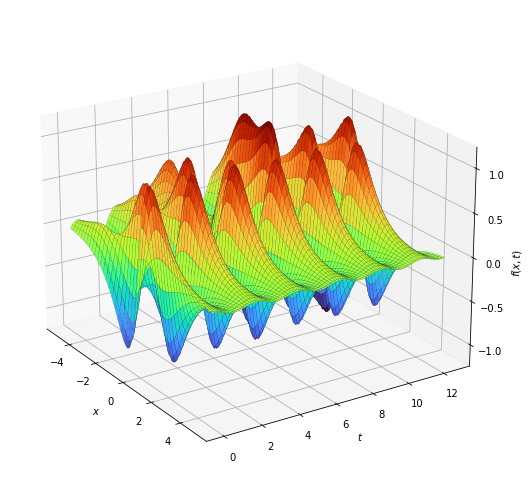

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = int(1e2)
m = int(1e3)

x = np.linspace(-5, 5, n)
t = np.linspace(0, 4 * np.pi, m)
xx, tt = np.meshgrid(x, t)
dt = t[1] - t[0]

f_1 = np.multiply(1 / np.cosh(xx + 3), np.sin(tt) * np.exp(2.3j * tt))
f_2 = np.multiply(2.0 / np.cosh(xx) * np.tanh(xx), np.exp(2.8j * tt))
f = f_1 + f_2

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")
im = ax.plot_surface(
    xx, tt, f, cmap="turbo", rcount=int(1e2), edgecolor="black", linewidth=0.1
)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$f(x, t)$")
ax.view_init(22, -33)
fig.tight_layout()
plt.show()

We can define the matrices $\mathbf{X}$ and $\mathbf{X}$', and calculate $\mathbf{\Lambda}$ and $\mathbf{\Phi}$.

In [2]:
X = f[0:-1].T
X_prime = f[1::].T
u, s, vh = np.linalg.svd(X, full_matrices=False)
A_tilde = u.conj().T @ X_prime @ vh.conj().T @ np.linalg.inv(np.diag(s))
evals, W = np.linalg.eig(A_tilde)
evals = np.diag(evals)  # evals is now equal to Λ
phi = X_prime @ vh.conj().T @ np.linalg.inv(np.diag(s)) @ W

Let's plot the absolute values of the eigenvalues to see which ones are interesting.

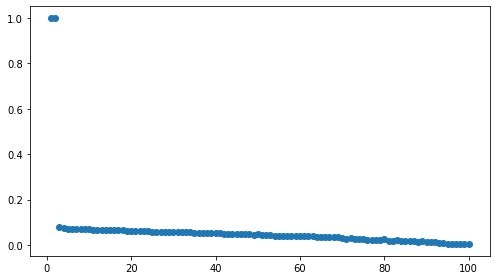

In [3]:
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(np.arange(evals.shape[0]) + 1, np.abs(np.diagonal(evals)))
fig.tight_layout()
plt.show()

We can see that only the modes corresponding to the two first eigenvalues are of interest here. It is important to note that we could have also seen this from the singular values given by SVD and truncated the resulting matrices.

Let's plot the modes.

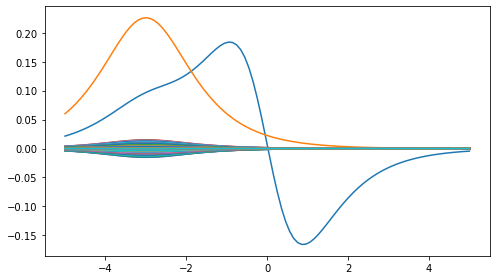

In [4]:
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(x, phi.real)
fig.tight_layout()
plt.show()

And finally let's reconstruct the time evolution of the whole system from the DMD results.

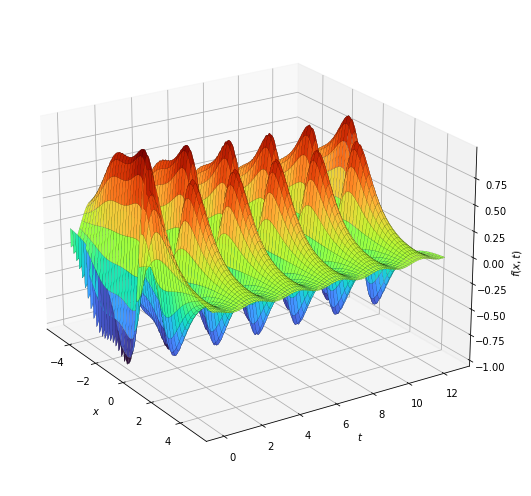

In [5]:
X_pred = np.zeros((n, m), dtype="complex")
X_pred[:, 0] = X[:, 0]
b = phi.conj().T @ X[:, 0]
for i in range(1, m):
    X_pred[:, i] = phi @ evals ** i @ b

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")
im = ax.plot_surface(
    xx, tt, X_pred.T.real, cmap="turbo", rcount=int(1e2), edgecolor="black", linewidth=0.1
)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$f(x, t)$")
ax.view_init(22, -33)
fig.tight_layout()
plt.show()